# Лабораторная работа №3

In [19]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

import os
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

### Импорт данных

In [2]:
df = pd.read_csv("Econom_Cities_data.csv", sep=";", index_col='City')
print(df.shape)
print(df.head())

(48, 3)
           Work Price Salary
City                        
Amsterdam  1714  65,6     49
Athens     1792  53,8   30,4
Bogota     2152  37,9   11,5
Bombay     2052  30,3    5,3
Brussels   1708  73,8   50,5


Приведем Price и Salary к числу 

In [3]:
df["Price"]  = pd.to_numeric(df["Price"].astype(str).str.replace(",", "."))
df["Salary"] = pd.to_numeric(df["Salary"].astype(str).str.replace(",", "."))

Проверяем чтобы все данные теперь были числовые

In [4]:
df.describe()

,Work,Price,Salary
count,48.000000,48.000000,48.000000
mean,1384.958333,68.860417,-378.727083
std,2404.897007,21.784659,2027.338052
min,-9999.000000,30.300000,-9999.000000
25%,1740.750000,49.650000,12.250000
50%,1834.500000,70.500000,40.300000
75%,1972.750000,81.700000,58.700000
max,2375.000000,115.500000,100.000000


### Убираем выбросы

In [5]:
# Определяем квартили и межквартильный размах
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# определяем нижнюю и верхнюю границы
lower = Q1 - 3.0 * IQR
upper = Q3 + 3.0 * IQR

# Определяем выбросы 
outlier_mask = ((df < lower) | (df > upper)).any(axis=1)

#  Отдельно сохраним выбросы и чистые данные 
outliers = df[outlier_mask]
df_clean = df[~outlier_mask]

# Вывод информации 
print(f"Количество выбросов: {outliers.shape[0]}")
print("Индексы (города) с выбросами:")
print(outliers.index.tolist())

print()
print('Дальше используем датафрейм df_clean')

Количество выбросов: 2
Индексы (города) с выбросами:
['Cairo', 'Jakarta']

Дальше используем датафрейм df_clean


### Стандартизируем данные

т.к. данные находятся в разных диапазонах, нужна стандартизация

Формула стандартизации: $z = \frac{x - \text{mean}}{\text{std}}$

In [6]:
scaler = StandardScaler() 
X_scaled = scaler.fit_transform(df_clean) 

X = pd.DataFrame(X_scaled, index=df_clean.index, columns=df_clean.columns)
print(X.round(2))

                Work  Price  Salary
City                               
Amsterdam      -0.96  -0.21    0.39
Athens         -0.51  -0.77   -0.37
Bogota          1.58  -1.52   -1.15
Bombay          1.00  -1.88   -1.40
Brussels       -1.00   0.17    0.45
Buenos_Aires    0.53  -0.66   -1.10
Caracas         0.93  -0.43   -1.17
Chicago         0.26   0.18    0.91
Copenhagen     -0.94   1.00    0.95
Dublin         -0.70   0.28    0.08
Dusseldorf     -1.08   0.40    0.84
Frankfurt      -1.33   0.21    0.85
Geneva          0.00   1.22    2.07
Helsinki       -1.23   2.06    1.10
Hong_Kong       2.87  -0.30   -0.48
Houston         0.57   0.09    0.28
Johannesburg    0.38  -0.90   -0.63
Kuala_Lumpur    1.66  -1.26   -1.21
Lagos          -0.54  -1.18   -1.50
Lisbon         -0.80  -0.66   -0.85
London         -0.83   0.67    0.27
Los_Angeles     1.09   0.46    1.05
Luxembourg     -0.65   0.05    1.29
Madrid         -0.99   1.12    0.43
Manila          2.25  -1.42   -1.45
Mexico_City     0.37  -0.96 

### Кластеризация

Пробуем значения по умолчанию

In [7]:
dbscan = DBSCAN()

#  Обучим модель DBSCAN
dbscan.fit(X)

dbscan.labels_

array([ 0, -1, -1, -1,  0, -1, -1, -1, -1,  0,  0, -1, -1, -1, -1, -1, -1,
       -1, -1, -1,  0, -1, -1, -1, -1, -1,  0,  0, -1, -1, -1, -1, -1,  0,
       -1, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1])

Посмотрим результат кластеризации

In [8]:
#  Создаем таблицу частот в pandas 
#  Команда value_counts() работает с таблицами, поэтому предварительно надо матрицу преобразовать в таблицу

table_ = pd.value_counts(pd.Series(dbscan.labels_))
table_.sort_index(inplace=True)

print(table_)

-1    36
 0    10
Name: count, dtype: int64


C:\Users\nikgr\AppData\Local\Temp\ipykernel_6360\3171365928.py:4: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  table_ = pd.value_counts(pd.Series(dbscan.labels_))


Получился 1 класс и 36 выбросов. Не годится

Нужно подобрать более качественные параметры

Попробуем перебрать сразу несколько eps и min_samples, пока не дойдем до оптимального варианта 

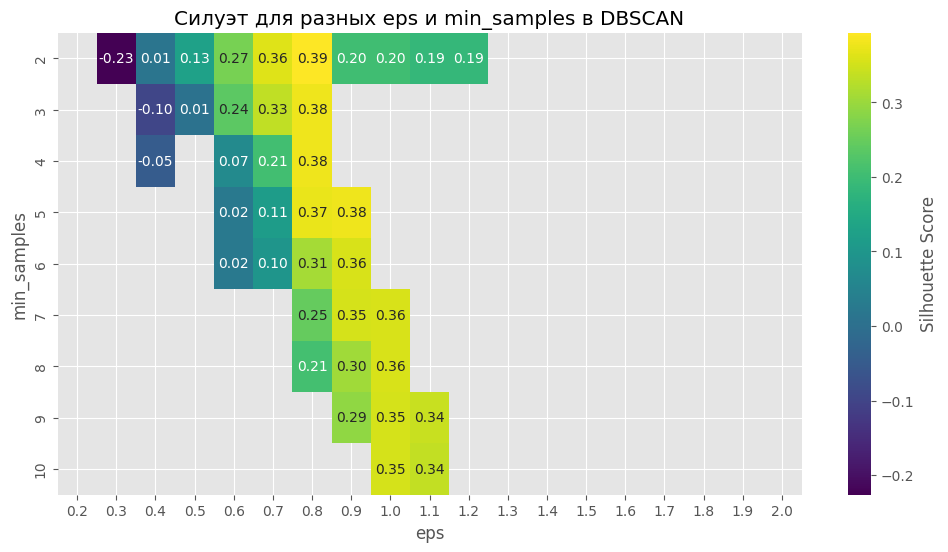

In [ ]:
eps_values = np.arange(0.2, 2.1, 0.1)
min_samples_values = range(2, 11)

silhouette_matrix = np.zeros((len(min_samples_values), len(eps_values)))

for i, min_samples in enumerate(min_samples_values):
    for j, eps in enumerate(eps_values):
        db = DBSCAN(eps=eps, min_samples=min_samples)
        labels = db.fit_predict(X)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

        if n_clusters > 1:
            score = silhouette_score(X, labels)
            silhouette_matrix[i, j] = score
        else:
            silhouette_matrix[i, j] = np.nan 

plt.figure(figsize=(12, 6))
sns.heatmap(silhouette_matrix, annot=True, fmt=".2f",
            xticklabels=np.round(eps_values, 2),
            yticklabels=min_samples_values,
            cmap="viridis", cbar_kws={'label': 'Silhouette Score'})
plt.xlabel("eps")
plt.ylabel("min_samples")
plt.title("Силуэт для разных eps и min_samples в DBSCAN")
plt.show()


При варианте ```eps = 0.8``` и ```min_samples = 2``` мы имеем самое хорошую метрику силуэта 

In [ ]:
min_samples = 2
for eps in [0.8]:
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(X)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    print(f"eps = {eps}: кол-во кластеров = {n_clusters}, кол-во выбросов = {n_noise}")

eps = 0.8: кол-во кластеров = 2, кол-во выбросов = 8


Кол-во кластеров при выбранных параметрах = 4 

Кол-во выбросов при выбранных параметрах = 4

In [28]:
dbscan = DBSCAN(eps=0.8, metric='euclidean', min_samples=2)

dbscan.fit(X)

table_ = pd.value_counts(pd.Series(dbscan.labels_))
table_.sort_index(inplace=True)

print(table_)

-1     4
 0    19
 1    19
 2     2
 3     2
Name: count, dtype: int64


C:\Users\nikgr\AppData\Local\Temp\ipykernel_6360\3848227430.py:5: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  table_ = pd.value_counts(pd.Series(dbscan.labels_))


При таком выборе мы имеем 2 кластера по 19 значений и 2 кластера по 2 значения

Это не оптимальный вариант потому что сильная разница в кол-ве значений. Попробуем следующий вариант по метрике силуэта 

```eps = 0.8``` и ```min_samples = 3```

In [38]:
min_samples = 3
for eps in [0.8]:
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(X)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    print(f"eps = {eps}: кол-во кластеров = {n_clusters}, кол-во выбросов = {n_noise}")

eps = 0.8: кол-во кластеров = 2, кол-во выбросов = 8


Кол-во кластеров при выбранных параметрах = 2

Кол-во выбросов при выбранных параметрах = 8

In [39]:
dbscan2 = DBSCAN(eps=0.8, metric='euclidean', min_samples=3)

dbscan2.fit(X)

table_2 = pd.value_counts(pd.Series(dbscan2.labels_))
table_2.sort_index(inplace=True)

print(table_2)

-1     8
 0    19
 1    19
Name: count, dtype: int64


C:\Users\nikgr\AppData\Local\Temp\ipykernel_6360\1540476046.py:5: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  table_2 = pd.value_counts(pd.Series(dbscan2.labels_))


При таком выборе гиперпараметров у нас получается 2 явных кластера и 8 шумов 

Остановимся на таком варианте 

In [40]:
#  Добавляем столбец cluster к таблице данных
df_clean['cluster'] = dbscan2.labels_

C:\Users\nikgr\AppData\Local\Temp\ipykernel_6360\1800879642.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['cluster'] = dbscan2.labels_


In [41]:
#  Средние значения в каждом кластере
df_clean.groupby('cluster').mean()

,Work,Price,Salary
cluster,,,
-1,1900.375000,99.925000,61.262500
0,1792.000000,77.526316,55.157895
1,1959.210526,50.115789,14.789474


In [42]:
#  Выведем состав каждого кластера
df_clean['cluster'].sort_values()

City
Hong_Kong        -1
Geneva           -1
Helsinki         -1
Oslo             -1
Taipei           -1
Tokyo            -1
Zurich           -1
Stockholm        -1
Dublin            0
Dusseldorf        0
Houston           0
Milan             0
Copenhagen        0
Brussels          0
Chicago           0
Amsterdam         0
Montreal          0
New_York          0
London            0
Toronto           0
Luxembourg        0
Los_Angeles       0
Madrid            0
Frankfurt         0
Vienna            0
Sydney            0
Paris             0
Bombay            1
Caracas           1
Bogota            1
Buenos_Aires      1
Athens            1
Nicosia           1
Nairobi           1
Mexico_City       1
Manila            1
Lisbon            1
Lagos             1
Kuala_Lumpur      1
Johannesburg      1
Seoul             1
Singpore          1
Rio_de_Janeiro    1
San_Paulo         1
Panama            1
Tel_Aviv          1
Name: cluster, dtype: int64

### Вывод по лабораторной работе

Исходя из полученных результатов, можно сделать следующие выводы:

**Кластер -1 - выбросы и аномалии в данных**

**Кластер 0 - сбалансированные и развитые города с хорошими зарплатами и умеренными ценами**

**Кластер 1 - недорогие, но низкооплачиваемые города с дешёвой рабочей силой**

## Общий вывод

В ходе лабораторных работ №1–3 была проведена кластеризация данных одного и того же датасета с использованием трёх различных методов:

- Иерархический метод — получено 4 кластера

- Метод K-Means — получено 5 кластеров

- Метод DBSCAN — получено 2 кластера

Сравнительный анализ показал, что наиболее наглядным и информативным для данного набора данных оказался иерархический метод кластеризации. Он позволяет легко визуализировать структуру данных и проследить взаимосвязи между объектами

Метод K-Means обладает меньшей наглядностью, потому что расстояния между кластерами не всегда очевидны. , но такой же простой и удобный как иерархический метод

Метод DBSCAN - удобный метод, который умеет выявлять аномалии и выбросы, однако требует тщательного подбора параметров (eps и min_samples), что делает его использование менее интуитивным и более трудоёмким

Таким образом, можно сделать следующие выводы по каждому методу:

- Иерархический метод — наиболее наглядный и информативный.

- K-Means — простой и достаточно эффективный, но менее визуально очевидный.

- DBSCAN — полезен для поиска аномалий, однако требует сложной настройки параметров.